In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from lightgbm import LGBMRegressor 

In [25]:
#read data
df_movies = pd.read_csv('../../Dataset/ml-25m/movies.csv')
df_ratings = pd.read_csv('../../Dataset/ml-25m/ratings.csv')

In [31]:
# df_movies year is extracted from the df_movies title
df_movies["movie_year"] = df_movies["title"].str.slice(start=-7,stop=-1)
df_movies["movie_year"] = df_movies.movie_year.str.extract('(\d+)')
df_movies["movie_year"] = pd.to_numeric(df_movies["movie_year"])
#step-by-step describe içindeki min movie_year değeri absürt olanları düşürdük 201'de son buldu
df_movies = df_movies.loc[(df_movies['movie_year'] > 201)].copy()

In [41]:
df_movies.describe()

In [45]:
#timestamp kolonu düşürüldü
df_ratings.drop(columns='timestamp', axis=1, inplace=True)
#boş satırlar düşürüldü
df_movies = df_movies.copy().dropna()
#genrelar ayırılarak yeni bir df oluşturuldu
genres = df_movies['genres'].str.get_dummies('|')
#ayırılmış genreler ve filmler birleştirilip 'genres' satırı düşürüldü
df_movies = pd.concat([df_movies,genres], axis=1)
df_movies.drop(columns='genres', axis=1, inplace=True)

In [46]:
#genre plotlama
genres_count = df_movies.sum(axis = 0, skipna = True)
genres_count = genres_count.to_frame()
genres_count = genres_count.drop(genres_count.index[range(3)])
genres_count.columns =['Count']
genres_count.reset_index(inplace=True)
genres_count.rename(columns={"index": "Genre"},inplace = True)
genres_count

,Genre,Count
0,(no genres listed),4054
1,Action,7114
2,Adventure,4058
3,Animation,2661
4,Children,2744
5,Comedy,15938
6,Crime,5099
7,Documentary,5082
8,Drama,24105
9,Fantasy,2632


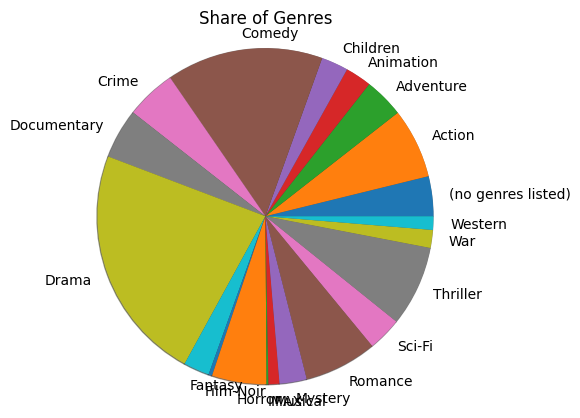

In [47]:
plt.pie(genres_count["Count"], labels = genres_count["Genre"],shadow=True,radius = 10, center = (5,5))
plt.title("Share of Genres")
plt.axis('equal')
plt.show()

In [51]:
#iki df'i birleştirmek
merged_df = pd.merge(df_movies, df_ratings)
merged_df

,movieId,title,movie_year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,userId,rating
0,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,4,4.0
1,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,10,5.0
2,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,14,4.5
3,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,15,4.0
4,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,22,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27746572,193878,Les tribulations d'une caissière (2011),2011.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,176871,2.0
27746573,193880,Her Name Was Mumu (2016),2016.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,81710,2.0
27746574,193882,Flora (2017),2017.0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,33330,2.0
27746575,193886,Leal (2018),2018.0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,206009,2.5


In [57]:
df_for_lightgbm = merged_df.copy()
df_for_lightgbm.head(5)

,movieId,title,movie_year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,userId,rating
0,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,4,4.0
1,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,10,5.0
2,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,14,4.5
3,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,15,4.0
4,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,22,4.0


In [58]:
#title, '(no genres listed)', 'userId' featureları çıkartıldı?!?!
df_for_lightgbm = df_for_lightgbm[df_for_lightgbm.columns.difference(['title', '(no genres listed)', 'userId'])].copy()
column_names = df_for_lightgbm.columns


In [64]:
#normalize edildi
df_for_lightgbm_normalized = preprocessing.normalize(df_for_lightgbm)
df_for_lightgbm_normalized = pd.DataFrame(df_for_lightgbm_normalized,columns = column_names)

In [66]:
df_for_lightgbm_normalized.head(5)

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movieId,movie_year,rating
0,0.0,0.000501,0.000501,0.000501,0.000501,0.0,0.0,0.0,0.000501,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000501,0.999997,0.002005
1,0.0,0.000501,0.000501,0.000501,0.000501,0.0,0.0,0.0,0.000501,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000501,0.999996,0.002506
2,0.0,0.000501,0.000501,0.000501,0.000501,0.0,0.0,0.0,0.000501,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000501,0.999997,0.002256
3,0.0,0.000501,0.000501,0.000501,0.000501,0.0,0.0,0.0,0.000501,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000501,0.999997,0.002005
4,0.0,0.000501,0.000501,0.000501,0.000501,0.0,0.0,0.0,0.000501,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000501,0.999997,0.002005


In [67]:
X = df_for_lightgbm_normalized[df_for_lightgbm_normalized.columns.difference(['rating'])]
y = df_for_lightgbm_normalized['rating']


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=31)

MemoryError: Unable to allocate 2.78 GiB for an array with shape (21, 17757808) and data type float64